In [38]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/캡스톤/거시경제및커피가격통합데이터.csv")

In [39]:
df['abs_return'] = df['Coffee_Price_Return'].abs()

# 5일, 10일 변동성 (rolling std)
df['volatility_5d'] = df['Coffee_Price_Return'].rolling(window=5).std()
df['volatility_10d'] = df['Coffee_Price_Return'].rolling(window=10).std()

# 5일 평균 수익률
df['momentum_5d'] = df['Coffee_Price'] - df['Coffee_Price'].shift(5)

# Bollinger Band Width (상대 변동성)
rolling_mean = df['Coffee_Price'].rolling(window=20).mean()
rolling_std = df['Coffee_Price'].rolling(window=20).std()
df['bollinger_width'] = (2 * rolling_std) / rolling_mean

# Return Z-score (비정상 변동 탐지)
df['return_zscore'] = (df['Coffee_Price_Return'] - df['Coffee_Price_Return'].rolling(20).mean()) / \
                       (df['Coffee_Price_Return'].rolling(20).std() + 1e-6)

df['momentum_1d'] = df['Coffee_Price'].diff(1)
df['momentum_3d'] = df['Coffee_Price'].diff(3)
df['volatility_ratio'] = df['volatility_5d'] / df['volatility_10d']

In [40]:
we = pd.read_csv("/content/drive/MyDrive/캡스톤/기후데이터피쳐선택.csv")

In [41]:
we.drop(columns=['Coffee_Price'], inplace=True)

In [42]:
df = pd.merge(df, we, on='Date', how='left')

In [43]:
df = df.dropna()

In [44]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [45]:
train_size = int(len(df) * 0.8)
train_df, test_df = df.loc[:df.index[train_size-1]], df.loc[df.index[train_size:]]

In [46]:
from sklearn.preprocessing import MinMaxScaler
return_train = train_df["Coffee_Price_Return"].copy()
return_test = test_df["Coffee_Price_Return"].copy()

scaler_seq = MinMaxScaler()
train_df = pd.DataFrame(scaler_seq.fit_transform(train_df),
                        columns=train_df.columns,
                        index=train_df.index)
train_df["Coffee_Price_Return"] = return_train

test_df = pd.DataFrame(scaler_seq.fit_transform(test_df),
                        columns=test_df.columns,
                        index=test_df.index)
test_df["Coffee_Price_Return"] = return_test

In [47]:
import numpy as np
import torch
from torch.utils.data import Dataset

class MultiStepTimeSeriesDataset(Dataset):
    def __init__(self, dataset, target, data_window, target_size, step, single_step=False):
        self.data, self.labels = [], []

        start_index = data_window
        end_index = len(dataset) - target_size  # 미래 예측을 고려해 끝점 조정

        for i in range(start_index, end_index):
            indices = range(i - data_window, i, step)  # X 데이터 생성 (샘플링 적용)
            self.data.append(dataset[indices])

            if single_step:
                self.labels.append(target[i + target_size])  # 단일 값 예측
            else:
                self.labels.append(target[i:i + target_size])  # 다중 스텝 예측

        # 리스트를 PyTorch Tensor로 변환
        self.data = torch.tensor(np.array(self.data), dtype=torch.float32)
        self.labels = torch.tensor(np.array(self.labels), dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [48]:
X_train = train_df.values
target_col = "Coffee_Price"
y_train = train_df[target_col].values

X_test = test_df.values
y_test = test_df[target_col].values

In [49]:
data_window = 50  # 최근 데이터를 입력으로 사용
future_target = 14  # 14개 미래 값 예측
step = 1  # 단위로 샘플링
train_dataset = MultiStepTimeSeriesDataset(X_train, y_train, data_window, future_target, step)
test_dataset = MultiStepTimeSeriesDataset(X_test, y_test, data_window, future_target, step)

LSTM 입력을 위해 3D 배열로 변경

In [50]:
X_train = train_dataset.data
y_train = train_dataset.labels

In [51]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

In [15]:
import torch.nn as nn
import torch.optim as optim

In [16]:
pip install entmax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [17]:
from entmax import Entmax15

class EntmaxAttention(nn.Module):
    def __init__(self, hidden_size, attn_dim=64):
        super().__init__()
        self.score_layer = nn.Sequential(
            nn.Linear(hidden_size, attn_dim),
            nn.Tanh(),
            nn.Linear(attn_dim, 1)
        )
        self.entmax = Entmax15(dim=1)

    def forward(self, lstm_output):
        # lstm_output: (B, T, H)
        scores = self.score_layer(lstm_output).squeeze(-1)  # (B, T)
        weights = self.entmax(scores)  # sparse attention weights
        context = torch.sum(lstm_output * weights.unsqueeze(-1), dim=1)  # (B, H)
        return context, weights

In [18]:
class AttentionLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=2, target_size=14, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.target_size = target_size

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        self.attention = EntmaxAttention(hidden_size)

        # Gating layer to mix context and last_hidden
        self.gate = nn.Sequential(
            nn.Linear(hidden_size * 2, 1),
            nn.Sigmoid()
        )

        # Nonlinear prediction head
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, target_size)
        )

    def forward(self, x, hidden_states=None):
        batch_size = x.size(0)

        if hidden_states is None:
            h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
            hidden_states = (h0, c0)

        lstm_out, _ = self.lstm(x, hidden_states)  # (B, T, H)

        context, attn_weights = self.attention(lstm_out)  # (B, H)
        last_hidden = lstm_out[:, -1, :]  # (B, H)

        # Gated fusion of context and last hidden
        combined = torch.cat([context, last_hidden], dim=1)  # (B, 2H)
        alpha = self.gate(combined)  # (B, 1)
        fused = alpha * context + (1 - alpha) * last_hidden  # (B, H)

        out = self.fc(fused)  # (B, target_size)

        return out, attn_weights

In [52]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_size = X_train.shape[2]
target_size = 14
model = AttentionLSTMModel(input_size=input_size, target_size=target_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [53]:
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        # 모델 예측 (hidden state 제거)
        y_pred, _ = model(x_batch)

        # (선택적으로) 차원 조정
        if y_pred.ndim == 3 and y_pred.shape[-1] == 1:
            y_pred = y_pred.squeeze(-1)

        # Loss 계산
        loss = criterion(y_pred, y_batch)

        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

Epoch [1/100], Loss: 0.0092
Epoch [2/100], Loss: 0.0026
Epoch [3/100], Loss: 0.0024
Epoch [4/100], Loss: 0.0024
Epoch [5/100], Loss: 0.0021
Epoch [6/100], Loss: 0.0019
Epoch [7/100], Loss: 0.0017
Epoch [8/100], Loss: 0.0017
Epoch [9/100], Loss: 0.0017
Epoch [10/100], Loss: 0.0016
Epoch [11/100], Loss: 0.0016
Epoch [12/100], Loss: 0.0015
Epoch [13/100], Loss: 0.0014
Epoch [14/100], Loss: 0.0015
Epoch [15/100], Loss: 0.0014
Epoch [16/100], Loss: 0.0013
Epoch [17/100], Loss: 0.0013
Epoch [18/100], Loss: 0.0013
Epoch [19/100], Loss: 0.0013
Epoch [20/100], Loss: 0.0015
Epoch [21/100], Loss: 0.0013
Epoch [22/100], Loss: 0.0017
Epoch [23/100], Loss: 0.0014
Epoch [24/100], Loss: 0.0012
Epoch [25/100], Loss: 0.0011
Epoch [26/100], Loss: 0.0011
Epoch [27/100], Loss: 0.0011
Epoch [28/100], Loss: 0.0011
Epoch [29/100], Loss: 0.0010
Epoch [30/100], Loss: 0.0010
Epoch [31/100], Loss: 0.0011
Epoch [32/100], Loss: 0.0010
Epoch [33/100], Loss: 0.0012
Epoch [34/100], Loss: 0.0010
Epoch [35/100], Loss: 0

예측 실행

In [54]:
model.eval()
predictions = []
prediction_dates_list = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        x_input, _ = test_dataset[i]
        x_input = x_input.unsqueeze(0).to(device)

        y_pred, _ = model(x_input)
        y_pred = y_pred.squeeze().cpu().numpy().reshape(-1, 1)

        # 역변환
        dummy = np.zeros((future_target, test_df.shape[1] - 1))
        combined = np.concatenate([y_pred, dummy], axis=1)
        y_inv = scaler_seq.inverse_transform(combined)[:, 0]

        # test_df에서 해당 시점의 실제 위치를 찾고, df 전체 인덱스로 변환
        base_test_index = i * step + data_window
        if base_test_index + future_target >= len(test_df):
            break

        start_timestamp = test_df.index[base_test_index]
        start_pos_in_df = df.index.get_loc(start_timestamp)

        date_range = df.index[start_pos_in_df + 1 : start_pos_in_df + 1 + future_target]
        if len(date_range) != future_target:
            continue

        predictions.append(pd.Series(y_inv, index=date_range))
        prediction_dates_list.extend(date_range)

In [55]:
predictions

[Date
 2022-07-13    203.508130
 2022-07-14    203.885196
 2022-07-15    204.449908
 2022-07-17    204.267469
 2022-07-18    203.979547
 2022-07-19    204.406044
 2022-07-20    204.785838
 2022-07-21    204.811464
 2022-07-22    206.451903
 2022-07-24    206.542239
 2022-07-25    206.978564
 2022-07-26    207.942735
 2022-07-27    208.426612
 2022-07-28    208.741394
 dtype: float64,
 Date
 2022-07-14    203.416086
 2022-07-15    203.790038
 2022-07-17    204.352941
 2022-07-18    204.169067
 2022-07-19    203.882035
 2022-07-20    204.311053
 2022-07-21    204.689275
 2022-07-22    204.715684
 2022-07-24    206.349119
 2022-07-25    206.445237
 2022-07-26    206.882974
 2022-07-27    207.841452
 2022-07-28    208.325465
 2022-07-29    208.649143
 dtype: float64,
 Date
 2022-07-15    203.532233
 2022-07-17    203.901043
 2022-07-18    204.462564
 2022-07-19    204.273008
 2022-07-20    203.984001
 2022-07-21    204.412853
 2022-07-22    204.787605
 2022-07-24    204.810077
 2022-07-25 

In [62]:
all_preds = pd.concat(predictions)
print("Min prediction:", all_preds.min())
print("Max prediction:", all_preds.max())

Min prediction: 152.95521873608232
Max prediction: 216.65286177396777


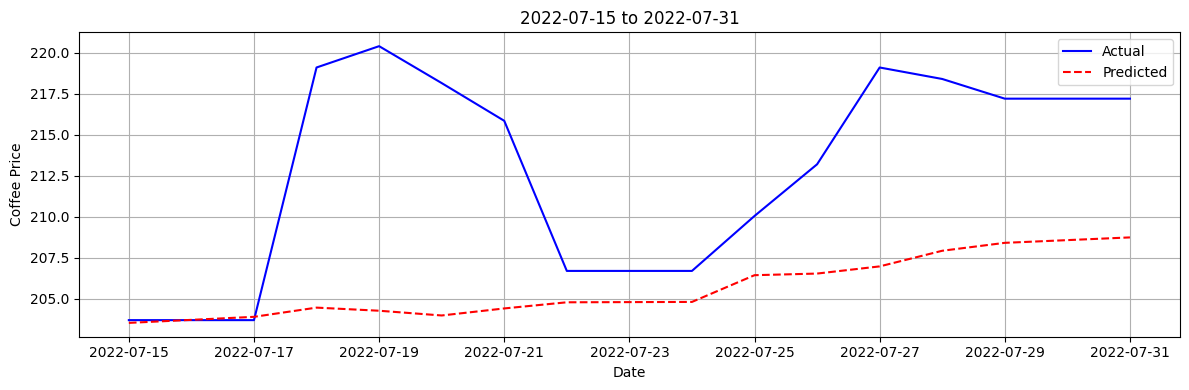

In [61]:
# 특정 인덱스 예측만 보기 (예: 3번째 예측 시퀀스)
k = 2
pred_k = predictions[k]
start_date = pred_k.index[0]
end_date = pred_k.index[-1]
true_k = df[target_col].loc[start_date:end_date]

plt.figure(figsize=(12, 4))
plt.plot(true_k.index, true_k.values, label='Actual', color='blue')
plt.plot(pred_k.index, pred_k.values, label='Predicted', color='red', linestyle='dashed')
plt.title(f"{start_date.date()} to {end_date.date()}")
plt.xlabel("Date")
plt.ylabel("Coffee Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

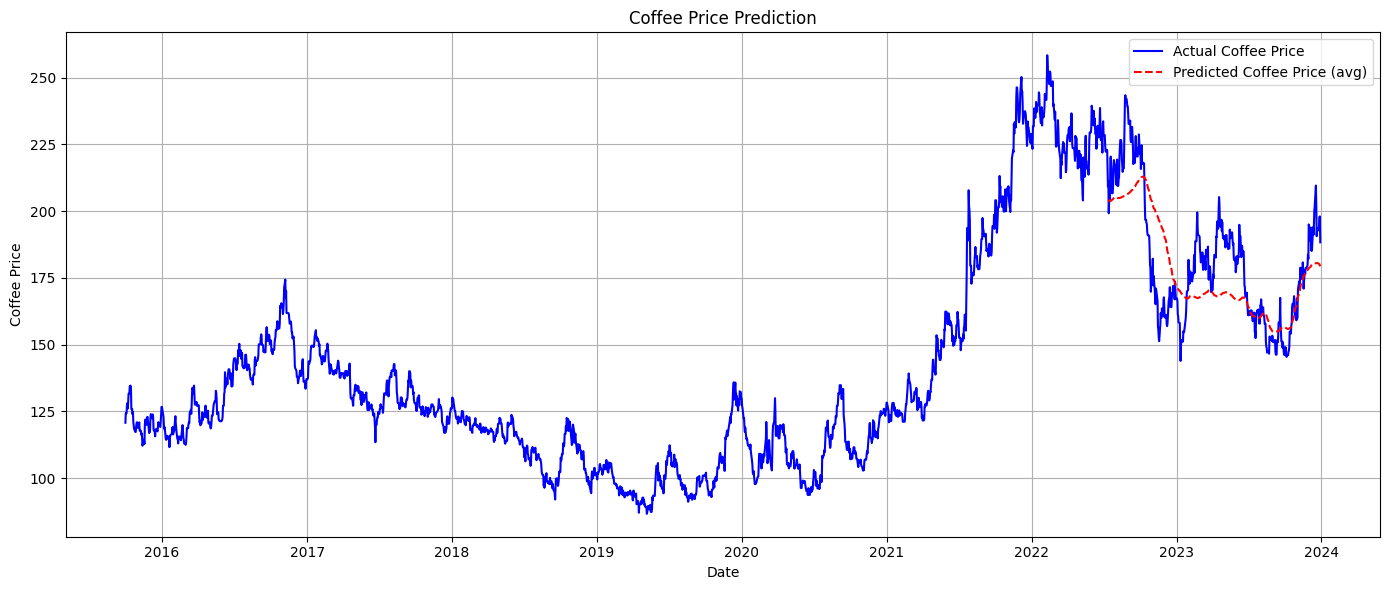

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
forecast_all = pd.concat(predictions, axis=1).mean(axis=1)  # 겹치는 날짜 평균

# 실제값과 예측값 비교 시각화
plt.figure(figsize=(14, 6))
plt.plot(df[target_col], label='Actual Coffee Price', color='blue')
plt.plot(forecast_all.index, forecast_all.values, label='Predicted Coffee Price (avg)', color='red', linestyle='dashed')

plt.title('Coffee Price Prediction')
plt.xlabel('Date')
plt.ylabel('Coffee Price')
# plt.xlim(pd.to_datetime('2021-11-01'), pd.to_datetime('2023-02-01'))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()